#1. Spark Streaming Introduction.
Basically we want to process data in real time as it's recieved.

### Why Spark Streaming?
* "Big data" never stops!
* Analyze data streams in real time, instead of in huge batch jobs daily. (Scalability concerns)
* Analyzing streams of web log data to react to user behavior.
* Analyze streams of real-time sensor data for "IOT".

### Spark streaming high level
You basically have a bunch of data streams coming in from Flume, Kafka, etc... And the spark cluster has recievers of data spread out across the cluster -> then Spark streaming discretizes that information coming in that stream into little chunks. You can give it a batch increament time, and it will split that data up in a little (one-sec, three-sec whatever is appropiate and you specify) increment, and it will split that data into individual RDDs and each RDD within that stream of data will contain some discretized cunk of data recieved over some small time period -> from there you can take that data and process it like any other stream RDD or in Spark across the Spark cluster.

NOTE: Spark streaming is not really real-time, it deals with micro-batches.

The work can be distributed, so the processing of RDD's can happen in parallel on different worker nodes.

### DStreams (Discretized Streams)
* Generates the RDD's for each time step, and can produce output at each time step.
* Can be transformed and acted on in much the same way as RDD's.
  - As each batch is recieved, perform X operation.
  - You perform the operations on a DStream and that gets applied every time you recieve a Batch.
* Or you can acess their underlying RDD's if you need them.


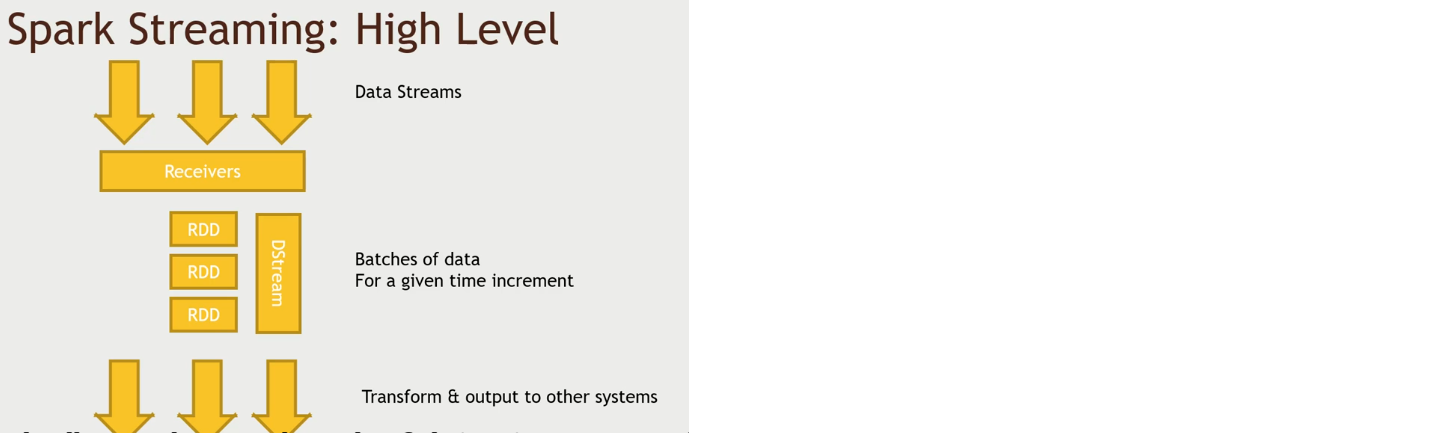

### Common stateless transformations on DStreams.
Basically the most powerfull things you can do on a SparkRDD you can do on a DStream
* Map
* Flatmap
* Filter
* reduceByKey

### Stateful data
You are not limited to processing these little micro-batches.
* You can also maintain a long-lived state on a Dstream.
  - For example - running totals, broken down by keys (Moving average).
  - Another example: aggregating session data in web activity.

Basically you can maintain state over a period of time with a DStream

### This can be done by using WINDOWING. 
* Windowed transformations allow you to compute results across a longer time period than your batch interval.
  - Example: top-sellers from the past-hour
    + You might process data every one second (The batch interval)
    + But maintain a window of one hour.
* The window "slides" as time goes on, to represent batches within the window interval.

### Windowing has 3 different intervals:
* **Batch interval**: This is how often data is captured into a DStream.
* **Slode interval**: How often a windowed transformation is computed.
  - "I want to compute top sellers for the past hour every past hour"
* **The window interval**: How far back in time the windowed transformation goes.
  - This would be the 1 hour time.

###Example 
* Each batch contains one second of data (the batch interval)
* We set up a window interval of 3 seconds and a slide interval of 2 seconds.
So every sec you generate a batch of info, every two seconds you compute result. And because your window is 3 seconds, you add that to the compute result when possible.





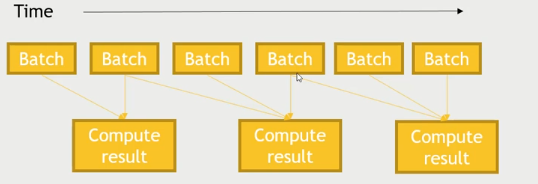

### Windowed transformations: code
* The batch interval is set up with your sparkContext:
`ssc = StreamingContext(sc,1)` (This is python)
  - We created a streaming context based on a given SPARK context with a batch interval of 1.
* You can use reduceByWindow() or reduceByKeyAndWindow() to aggreagate data across a longer period of time.
`hashtagCounts=hashtagKeyValues.reduceByKeyAndWindow(lambda: x,y:x+y, lambda x,y:x-y, 300, 1)`
  - We call that function on a DStream. (the 300 is the window, the 1 is the slide window).
  - So every 1 second go back 5 min (300 secs) and do the function.

### STRUCTURED STREAMING.

* Structured streaming is a new higher-level API for streaming structured data.
  - Availiable in spark 2.0 and 2.1 as an experimental release.
  - **ITS THE FUTURE**

* Structured streaming uses DataSets
  - Like a DataFrame, but with more explicit type information.
  - A DataFrame is really a DataSet[Row]

**Imagine a DataFrame that never ends**
 * New data just keeps getting appended to it.
 * Your continous application keeps querying updated data as it comes in.

So it looks just like dealing with a DStream but Data is just added continously and there are new operations to perform on the DataFrame



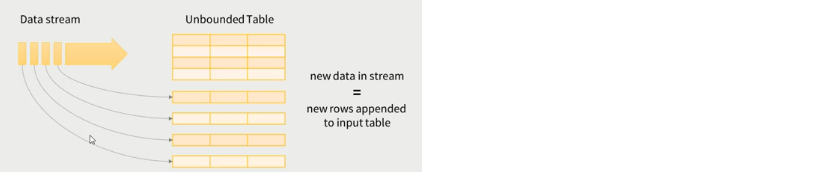

### Advantages of Structured Streaming.

* Streaming code looks a lot like the equivalent non-streaming code
  - Easy to adapt

* Structured data allows Spark to represent data more efficiently
* SQL-style queries allow for query optimization opportunities - and even better performance.
* Interoperability with other Spark components based on DataSets.
  - MLLib is also moving toward DataSets as its primary API.
* Datasets in general is the direction Spark is moving.




### Once you have a SparkSession, you can stream data, query it, and write out the results.

```
val inputDF = spark.readStream.json("s3://logs")
inputDF.groupBY($"action", window($"time","1 hour")).count().writeStream.format("jdbc").start("jdbc:mysql//...")
```
With that code you can stream in structured JSON log data, count up "action" values each hour, and write the results to a database.



# 2. [Activity] Analyze web logs published with Flume using Spark Streaming

### Excercise: Spark streaming with Flume.

* We'll set up Flume to use a spooldir source as before.
* But use an Avro sink to connect it to our Spark Streaming job!
  - Use a window to aggregate how often each unique URL appears from our access log.
* Using Avro in this manner is a "push" mechanism to Spark Streaming.
  - You can also "pull" data by using a custom sink for Spark Streaming.

This -> uses flume to monitor a directory for new logs -> Flume then writes the data in AVRO format to a specific port on the localhost (You could write to HDFS or anything really) -> Then SparkStreaming listens to that port and recieves the data in Avro format from flume automatically. -> The SparkStreaming will count how many times each unique url appears in the web log over some window of time.

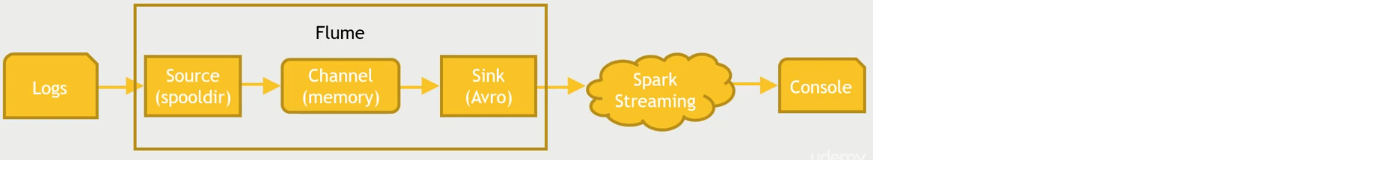

1. Open the HDP in virtualbox and open PuTTY
2. Lets configure Flume to talk to Spark Streaming instead of dumping data into HDFS. In our previous session we set up Flume to monitor a SPOOL directory inside the home directory for new files that get dropped into it and we direct the data into HDFS, now we will send it to AVRO. 
  - This is done by modifing the Flume configuration, the file is in; `wget media.sundog-soft.com/hadoop/sparkstreamingflume.conf` and we take a look `less sparkstreamingflume.conf`
  - This is the same one as before but the sink.type variable has changed, it's now = avro. And it comunicates on port 9092

Now lets take a look at the spark streaming script itself: `wget http://media.sundog-soft.com/hadoop/SparkFlume.py` -> `cat SparkFlume.py` and we can see the script, but it's better to see in a real editor

In [0]:
import re

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.flume import FlumeUtils

# First we set a Regular expression (RegEx)
# Basicallly it's a pattern matching language
# that says this is how i'm going to actually extract it
# extract information from a line of Apache log data.
# You basically encode the format of a line of an Apache
# web server access log.
# Each line consists of a Host, some id, some user, time, req, etc...
parts = [
    r'(?P<host>\S+)',                   # host %h
    r'\S+',                             # indent %l (unused)
    r'(?P<user>\S+)',                   # user %u
    r'\[(?P<time>.+)\]',                # time %t
    r'"(?P<request>.+)"',               # request "%r"
    r'(?P<status>[0-9]+)',              # status %>s
    r'(?P<size>\S+)',                   # size %b (careful, can be '-')
    r'"(?P<referer>.*)"',               # referer "%{Referer}i"
    r'"(?P<agent>.*)"',                 # user agent "%{User-agent}i"
]
 
pattern = re.compile(r'\s+'.join(parts)+r'\s*\Z')

# A map function that takes a raw line from an Apache acess log 
# and extracts the URL that was requested from it.
def extractURLRequest(line):
    exp = pattern.match(line) #with the Regex runs a 
    # match agains the incoming data
    if exp: #if it finds a match against the pattern
      # it will group that into a dictionary and extract the request
      # field from it. That consists of 3 different fields-
      request = exp.groupdict()["request"] 
      if request: # The second filed gets split again.
          requestFields = request.split()
          if (len(requestFields) > 1): # The URL is one of those
            # If the URL is valid we get it.
              return requestFields[1]

# Now Spark streaming starts.

if __name__ == "__main__":

    #Set the spark context object and give it a name
    sc = SparkContext(appName="StreamingFlumeLogAggregator")
    sc.setLogLevel("ERROR") #set the logs only to see the errors
    ssc = StreamingContext(sc, 1) # set the context with an interval of 1 second.
    # Every second we look for new data and create a new RDD in our DStream

    # We are connecting to flume (through avro (because of the config file?))
    flumeStream = FlumeUtils.createStream(ssc, "localhost", 9092)
    # Note: There are 2 ways of connecting to flume, this is a Push model
    # Where we are pushing model from flume into sparks streaming using Avro.
    # It looks as if you were pushing data from one flume agent to another.
    # The second model is a pole model, where you actually use a custom
    # sync within flume to establish a more bi-directional relationship
    # Between flume and SparkStreaming (This tends to be more robust)
  
    # Now that we have the DStream object (flumeStream)
    # we apply the map object to extract the actual line of information
    # from each line of data that comes into the DStream over time.
    # NOTE: Every second this functions happen.
    lines = flumeStream.map(lambda x: x[1])
    urls = lines.map(extractURLRequest)

    # Reduce by URL over a 5-minute window sliding every second
    # First we map the URLS to a tuple of (URL,1) and then we add those all up
    # now we know how many times the URL appears.
    # Note the 300 and 1 mean the window and the interval
    urlCounts = urls.map(lambda x: (x, 1)).reduceByKeyAndWindow(lambda x, y: x + y, lambda x, y : x - y, 300, 1)

    # Sort and print the results.
    sortedResults = urlCounts.transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    sortedResults.pprint()

    # Set a checkpoint to mantain the states somewhere.
    # This is needed
    ssc.checkpoint("/home/maria_dev/checkpoint")
    ssc.start() #Start
    ssc.awaitTermination() #Wait until the user stops the job

To run it now
1. in PuTTY -> make the checkpoint directory (We are in the home directory) -> `mkdir checkpoint`. We also need to tell it to use Spark 2.0 `export Spark_Major_Version = 2`

2. `spark-submit --packages org.apache.spark:spark-streaming-flume_2.11:2.0.0 SparkFlume.py` the last part is specifying versions. You need to check your versions for compatibility.
  - NOTE: Flume is not running right now, but in the console we see every second it returns a result.

3. To start flume -> Open a new PuTTY console: `cd /usr/hdp/current/flume-server/` -> `bin/flume-ng agent --conf conf --conf-file ~/sparkstreamingflume.conf --name a1` so we tell it to start flume with that conf and the agent a1.

4. We start a third PuTTY window -> We copy some info there -> `http://media.sundog-soft.com/hadoop/acess_log.txt` -> we drop it into the spool directory `cp access_log.txt spool/log22.txt` (The last part is the text)

Now we should see the data being agregated in the Spark flume console.

NOTE: This can be useful info
  - Eg. if you see one URL constantly pinging you, that means it might be a Hacker or a bot or something.

Exit and clean everything.

So recap: 
  * We set up flume to monitor the spool directory
  * flume publishes that data through avro to SparkStreaming 
  * And we've used a windowed interval and Spark's streaming to aggregate data in a stateful manner across the past five min.


#3. [Exercise] Monitor Flume-published logs for errors in real time
This is to be done by me:
* Take the Sparkflume.py script
  - Instead of aggregating how many times each you URL is seen, figure out how many times each HTTP status code is seen.
    + NOTE: HTTP status code is something that gets returned whenever you hit a web-server. You can get a sucessful request (200), you can get server error or redirect (500, 301 or 302).
    + In the script there is a field called status, so instead of extracting URLs and agreggating on that, do it on the Status.
  - Change the slide interval, so instead of working every 1 sec do it every 5 sec.




In [0]:
import re

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.flume import FlumeUtils

# First we set a Regular expression (RegEx)
# Basicallly it's a pattern matching language
# that says this is how i'm going to actually extract it
# extract information from a line of Apache log data.
# You basically encode the format of a line of an Apache
# web server access log.
# Each line consists of a Host, some id, some user, time, req, etc...
parts = [
    r'(?P<host>\S+)',                   # host %h
    r'\S+',                             # indent %l (unused)
    r'(?P<user>\S+)',                   # user %u
    r'\[(?P<time>.+)\]',                # time %t
    r'"(?P<request>.+)"',               # request "%r"
    r'(?P<status>[0-9]+)',              # status %>s
    r'(?P<size>\S+)',                   # size %b (careful, can be '-')
    r'"(?P<referer>.*)"',               # referer "%{Referer}i"
    r'"(?P<agent>.*)"',                 # user agent "%{User-agent}i"
]
 
pattern = re.compile(r'\s+'.join(parts)+r'\s*\Z')

# A map function that takes a raw line from an Apache acess log 
# and extracts the URL that was requested from it.
def extractStatusRequest(line):
    exp = pattern.match(line) #with the Regex runs a 
    # match agains the incoming data
    if exp: #if it finds a match against the pattern
      # it will group that into a dictionary and extract the request
      # field from it. That consists of 3 different fields-
      status = exp.groupdict()["status"] #here should have been status 
      return status

# Now Spark streaming starts.

if __name__ == "__main__":

    #Set the spark context object and give it a name
    sc = SparkContext(appName="StreamingFlumeLogAggregator")
    sc.setLogLevel("ERROR") #set the logs only to see the errors
    ssc = StreamingContext(sc, 1) # set the context with an interval of 1 second.
    # Every second we look for new data and create a new RDD in our DStream

    # We are connecting to flume (through avro (because of the config file?))
    flumeStream = FlumeUtils.createStream(ssc, "localhost", 9092)
    # Note: There are 2 ways of connecting to flume, this is a Push model
    # Where we are pushing model from flume into sparks streaming using Avro.
    # It looks as if you were pushing data from one flume agent to another.
    # The second model is a pole model, where you actually use a custom
    # sync within flume to establish a more bi-directional relationship
    # Between flume and SparkStreaming (This tends to be more robust)
  
    # Now that we have the DStream object (flumeStream)
    # we apply the map object to extract the actual line of information
    # from each line of data that comes into the DStream over time.
    # NOTE: Every second this functions happen.
    lines = flumeStream.map(lambda x: x[1])
    urls = lines.map(extractStatusRequest)

    # Reduce by URL over a 5-minute window sliding every second
    # First we map the URLS to a tuple of (URL,1) and then we add those all up
    # now we know how many times the URL appears.
    # Note the 300 and 1 mean the window and the interval
    urlCounts = urls.map(lambda x: (x, 1)).reduceByKeyAndWindow(lambda x, y: x + y, lambda x, y : x - y, 300, 5)

    # Sort and print the results.
    sortedResults = urlCounts.transform(lambda rdd: rdd.sortBy(lambda x: x[1], False))
    sortedResults.pprint()

    # Set a checkpoint to mantain the states somewhere.
    # This is needed
    ssc.checkpoint("/home/maria_dev/checkpoint")
    ssc.start() #Start
    ssc.awaitTermination() #Wait until the user stops the job

To run it you do the same steps as before. (With the edited SparkFlume.py file)

#1. Apache STORM  Introduction
Another way of processing continous streams of data, this is more real-time in nature.

### What is Storm?
* Another framework for processing continous streams of data on a cluster.
  - Can run on top of YARN (like Spark)
* Works on individual events, not micro-batches.
  - If you need sub-second latency, Storm is for you


### Storm terminology.
* A stream consists of tuples that flow through...
* Spouts that are sources of stream data (Kafka, twitter,etc...) 
* Bolts that process strem data as it's recieved.
  - Transform, aggregate, write to databases/ HDFS
* A topology is a graph of spouts and bolts that process your stream.

### Storm architecture.
* It has a Nimbus node (A server), it's kind of a job tracker.
* Then everything goes through Zookeeper
* Then it is passed through supervisors where the work actually happens.


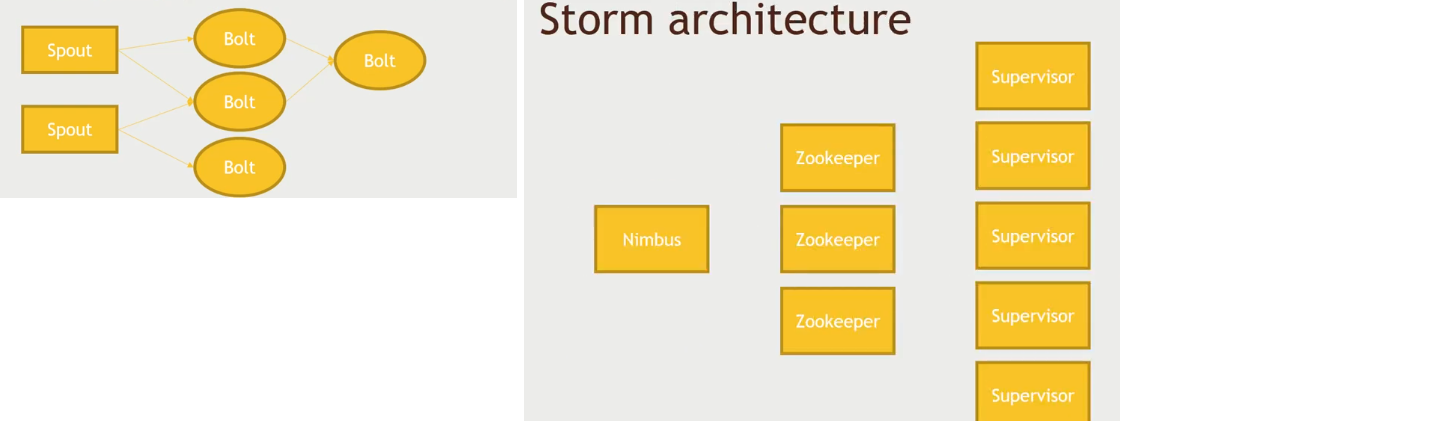

### Developing Storm applications
* Usually done with Java
  - Although bolts may be directed through scripts in other languages.
* Storm Core
  - The lower-level API for Storm
  - "At least once" semantics 
    + There is a posibility of recieving duplicate data.
* Trident 
  - Higher-level API for Storm
  - "Exactly once" semantics
* Storm runs your applications "forever" once submitted - until you explicitly stop them.

### Storm vs. Spark Streaming

* There's something to be said for having the rest of Spark at your disposal. (Spark has a larger environment) 

* But if oyu need truly real-time processing (sub-second) of events as they come in ,Storm's your choice.

* Core Storm offers "tumbling windows" in addition to "sliding windows".
  - tumbling window: As data comes in I want all events that came in EXACTLY the past 5 seconds.
    + You can make sure there is no overlap in events.

* Kafka + Storm seems to be a pretty popular combination.





Activity:
* Run the WordCount topology example and examine it.
  - We have a Spout that generates random sentences -> hook that into a Bolt that splits the sentences -> connect to another bolt that keeps count of the words.

  Basically a giant hashmap.

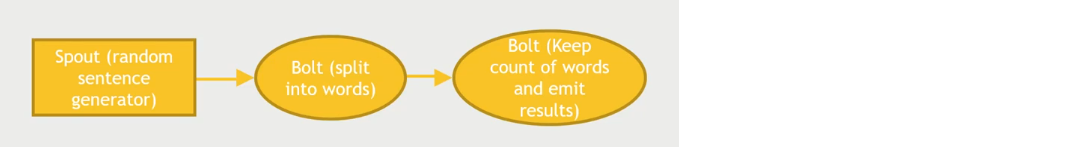

# 6. Activity: Count words with Storm

1. Go into ambari (127.0.0.1:8080) -> go into the Storm service -> Start service. We also need Kafka running -> Kafka -> Start service.
2. Open PuTTY -> `cd /usr/hdp/current/storm-client/contrib/` -> `cd storm-starter/src/jvm/org/apache/storm/` 'storm-stater' is the tutorial -> `cd starter` Here are plenty of tutorial examples. (They are in Java) -> `vi WordCountTopology.java` and we can see the java code.

NOTE: Storm is bascially in JAVA.

Some notes about the code:
* You declare a WordCountTopology class. 
* And others. 
* Basically it's java code that does what we want.

3. To run the program: `storm jar /usr/hdp/current/storm-client/contrib/storm-starter/storm-starter-topologies-*.jar org.apache.storm.starter.WordCountTopology wordcount`

4. You can look at the storm ui in '127.0.0.1:8744' and see your jobs, supervisors, workers, supervisors, etc...

5. You want to kill the job and the service because else it will run forever

6. To see the logs: the process outputs a worker.log and in that file there is the data.



In [0]:
package org.apache.storm.starter;

import java.util.HashMap;
import java.util.Map;
import org.apache.storm.starter.spout.RandomSentenceSpout;
import org.apache.storm.task.ShellBolt;
import org.apache.storm.topology.BasicOutputCollector;
import org.apache.storm.topology.ConfigurableTopology;
import org.apache.storm.topology.IRichBolt;
import org.apache.storm.topology.OutputFieldsDeclarer;
import org.apache.storm.topology.TopologyBuilder;
import org.apache.storm.topology.base.BaseBasicBolt;
import org.apache.storm.tuple.Fields;
import org.apache.storm.tuple.Tuple;
import org.apache.storm.tuple.Values;

/**
 * This topology demonstrates Storm's stream groupings and multilang
 * capabilities.
 */
public class WordCountTopology extends ConfigurableTopology {
    public static void main(String[] args) throws Exception {
        ConfigurableTopology.start(new WordCountTopology(), args);
    }

    @Override
    protected int run(String[] args) throws Exception {

        TopologyBuilder builder = new TopologyBuilder();

        builder.setSpout("spout", new RandomSentenceSpout(), 5);

        builder.setBolt("split", new SplitSentence(), 8).shuffleGrouping("spout");
        builder.setBolt("count", new WordCount(), 12).fieldsGrouping("split", new Fields("word"));

        conf.setDebug(true);

        String topologyName = "word-count";

        conf.setNumWorkers(3);

        if (args != null && args.length > 0) {
            topologyName = args[0];
        }
        return submit(topologyName, conf, builder);
    }

    public static class SplitSentence extends ShellBolt implements IRichBolt {

        public SplitSentence() {
            super("python", "splitsentence.py");
        }

        @Override
        public void declareOutputFields(OutputFieldsDeclarer declarer) {
            declarer.declare(new Fields("word"));
        }

        @Override
        public Map<String, Object> getComponentConfiguration() {
            return null;
        }
    }

    public static class WordCount extends BaseBasicBolt {
        Map<String, Integer> counts = new HashMap<String, Integer>();

        @Override
        public void execute(Tuple tuple, BasicOutputCollector collector) {
            String word = tuple.getString(0);
            Integer count = counts.get(word);
            if (count == null) {
                count = 0;
            }
            count++;
            counts.put(word, count);
            collector.emit(new Values(word, count));
        }

        @Override
        public void declareOutputFields(OutputFieldsDeclarer declarer) {
            declarer.declare(new Fields("word", "count"));
        }
    }
}

#7. Flink An Overview

* German for quick and nimble
* Another stream processing engine - most similar to Storm.
* Can run on standalone cluster, or on top of YARN or Mesos.
* Highly scalable (1000's of nodes)
* Fault-tolerant
  - Can survive failures while still guaranteeing exactly-once processing
  - Uses "state snapshots" to achieve this.
* Up & coming quickly.

### Flink vs Spark Streaming vs Storm
NOTE: This change fast since the 3 techs are actively developed.

* Flink is faster than Storm
* Flink offers "real streaming" like Storm
* Flink offers a higher-level API like Trident or Spark, but maintains real-time streaming.
* Flink has good Scala support
* Flink has an ecosystem of its own. (like Spark)
* Flink can process data based on event times, not when data was recieved.
  - Impressive windowing system
  - This plus real-time streaming and exactly-once semantics is important for financial applications.
* Flink is the youngest of the technologies.

NOTE: All 3 solutions seem to be converging. So it's basically a question of what best fits with your existing environment. What is available


### Flink architecture.

* It can run on a Standalone cluster. It can run on top of YARN and Hadoop, AWS, Google Cloud or a simple local.

FLINK can process streaming and batch data. 
* DataStream Api: which can do Event processing and table processing (for SQL)
* DataSetAPI: Deals with batch data (FlinkML, Gelly(graphics), Table (for SQL)) 


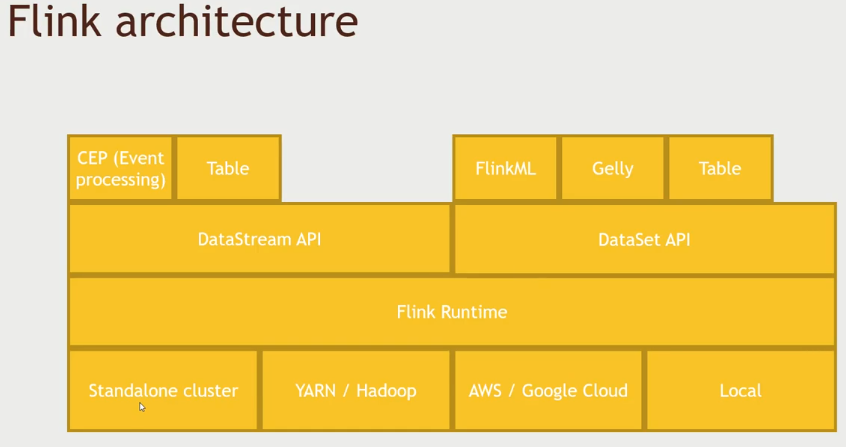

### Connectors:
* HDFS
* Cassandra
* Kafka 
* Others
  - Elasticsearch, Nifi, Redis, RabbitMQ...



#8.[Activity] Counting words with Flink

Open HDP and PuTTY as usual.

You have to install flink -> go to flink.apache.org (in web browser). go to download and you get a list of mirrors to download from. Copy-paste the link and in PuTTY `wget link`

1. to uncompress `tar -xvf flink-.....` (the name of the file we downloaded)

2. We need to change the port that the WebUI runs on `cd conf` -> `vi flink-conf.yaml` and change the port (jobmanager.web.port) to 8082. -> esc `:wq` to quit vi -> `cd..` to the flink directory.

3. `./bin/start-local.sh` and flink is now started in local mode. -> go to `127.0.0.1:8082` to go to the flink dashboard.

4. We will count words, the code is in `https://github.com/apache/flink/blob/master/flink-examples/flink-examples-streaming/src/main/scala/org/apache/flink/streaming/scala/examples/socket/SocketWindowWordCount.scala` NOTE: THE CODE IS SCALA.

5. To actually run it we need to open up a port to listen to. For this we use NETCAT.
  + Netcat just lets you type things into the console and echo it out to a TCP port.
  + So we use `nc -l 9000` which just tells netcat to broadcast to the TCP port 9000.

6. In another PuTTY window we actually do the streaming job in flink. -> `cd flink-1.2.0` -> `./bin/flink run examples/streaming/SocketWindowWordCount.jar --port 9000` NOTE: The .jar is still scala code, but when you compile it, it gets that value.

7. In the socket dashboard you can see the running jobs.

8. In the netcat console you can now write anything.

9. Open up a third PuTTY console. -> `cd flink-1.2.0/log` and here the output should be, it is a .out file -> `cat flink-maria_dev-jobmanager-0-sandbox.hortonworks.com.out` and you get the word count of what you sent in the netcat console.

Now you shut down everything
NOTE: To kill flink service (in the netcat console) `./bin/stop-local.sh`

In [0]:

Skip to content
Pull requests
Issues
Marketplace
Explore
@g-vega-cl
Code Pull requests 528 Actions Security 0 Pulse Community
flink/flink-examples/flink-examples-streaming/src/main/scala/org/apache/flink/streaming/scala/examples/socket/SocketWindowWordCount.scala
@LingangJiang LingangJiang [hotfix] [examples] Distinguish 'netcat' arguments for Linux and Wind… 5c9caa7 on Jul 3, 2019
@StephanEwen
@WangTaoTheTonic
@LingangJiang
@ch33hau
82 lines (70 sloc) 3 KB
/*
 * Licensed to the Apache Software Foundation (ASF) under one
 * or more contributor license agreements.  See the NOTICE file
 * distributed with this work for additional information
 * regarding copyright ownership.  The ASF licenses this file
 * to you under the Apache License, Version 2.0 (the
 * "License"); you may not use this file except in compliance
 * with the License.  You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

package org.apache.flink.streaming.scala.examples.socket

import org.apache.flink.api.java.utils.ParameterTool
import org.apache.flink.streaming.api.scala._
import org.apache.flink.streaming.api.windowing.time.Time

/**
 * Implements a streaming windowed version of the "WordCount" program.
 * 
 * This program connects to a server socket and reads strings from the socket.
 * The easiest way to try this out is to open a text sever (at port 12345) 
 * using the ''netcat'' tool via
 * {{{
 * nc -l 12345 on Linux or nc -l -p 12345 on Windows
 * }}}
 * and run this example with the hostname and the port as arguments..
 */
object SocketWindowWordCount { #Create object

  /** Main program method */
  def main(args: Array[String]) : Unit = {

    # Listens to a given TCP socket on a given port for words
    # that come in.
    // the host and the port to connect to
    var hostname: String = "localhost"
    var port: Int = 0

    try { #Main function
      val params = ParameterTool.fromArgs(args)
      hostname = if (params.has("hostname")) params.get("hostname") else "localhost"
      port = params.getInt("port")
    } catch {
      case e: Exception => {
        System.err.println("No port specified. Please run 'SocketWindowWordCount " +
          "--hostname <hostname> --port <port>', where hostname (localhost by default) and port " +
          "is the address of the text server")
        System.err.println("To start a simple text server, run 'netcat -l <port>' " +
          "and type the input text into the command line")
        return
      }
    }
    
    // get the execution environment
    val env: StreamExecutionEnvironment = StreamExecutionEnvironment.getExecutionEnvironment
    
    # Start processing the streams of data.
    // get input data by connecting to the socket
    val text: DataStream[String] = env.socketTextStream(hostname, port, '\n')

    # Transform the counts, It's very similar to Spark code.
    // parse the data, group it, window it, and aggregate the counts 
    val windowCounts = text
          .flatMap { w => w.split("\\s") }
          .map { w => WordWithCount(w, 1) }
          .keyBy("word")
          .timeWindow(Time.seconds(5))
          .sum("count")

    // print the results with a single thread, rather than in parallel
    windowCounts.print().setParallelism(1)

    env.execute("Socket Window WordCount")
  }

  /** Data type for words with count */
  case class WordWithCount(word: String, count: Long)
}

